In [1]:
from mqt import run_mqt_bench_experiments_incremental

Generating sample data for demonstration...
Loaded 5417 experiments
Unique partition counts: [1, 2, 3, 4, 5, 6]
Strategies: ['global' 'local']

Grouped data:
   strategy  num_partitions_tested          mean           std  count
0    global                      1 -3.871513e-01  1.980363e+00    374
1    global                      2 -2.447798e+13  2.823761e+14    807
2    global                      3 -2.153317e+14  2.919962e+15    359
3    global                      4 -1.213951e+14  1.436758e+15    626
4    global                      5 -1.626236e+14  1.298973e+15    270
5    global                      6 -5.074367e+13  5.518517e+14    448
6     local                      1 -6.584718e-01  2.529113e+00    368
7     local                      2 -3.162674e+13  4.494924e+14    623
8     local                      3 -1.012031e+14  6.656707e+14    360
9     local                      4 -5.764935e+13  4.993573e+14    489
10    local                      5 -7.321285e+13  5.119857e+14    270
11

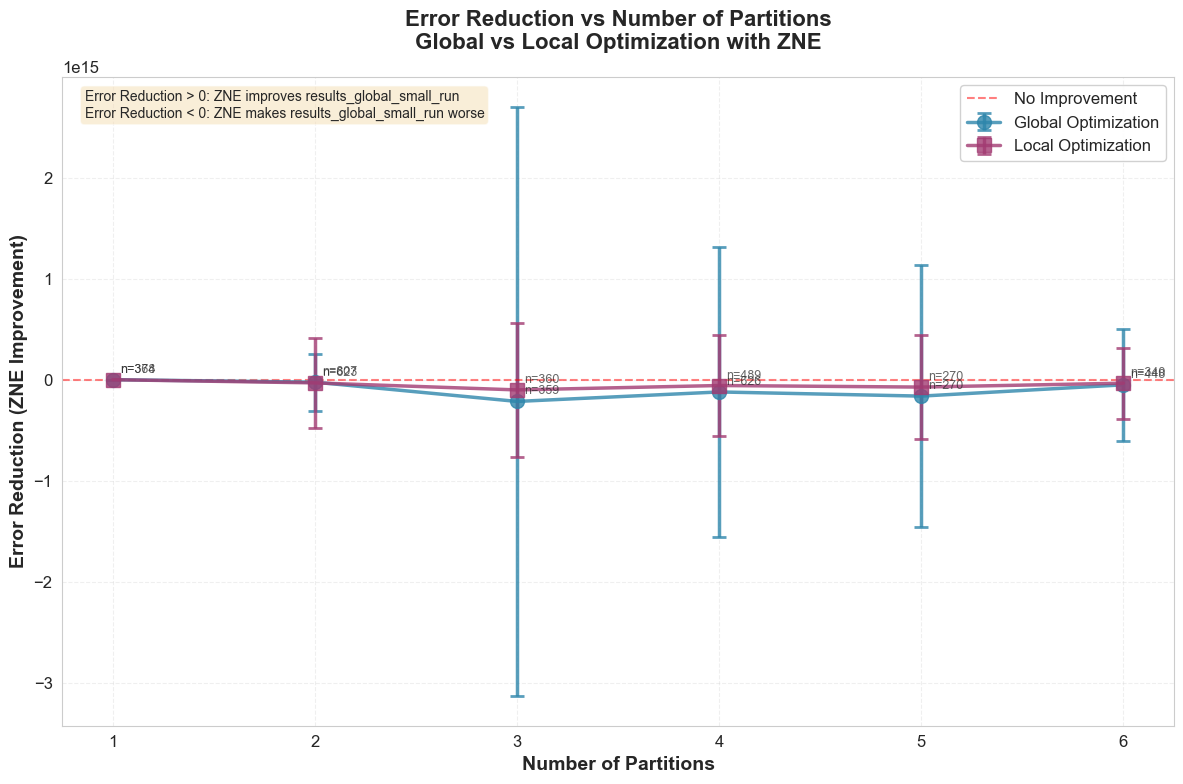


SUMMARY STATISTICS

GLOBAL Strategy:
  Partition counts tested: [1, 2, 3, 4, 5, 6]
  Mean error reduction: -95762003678960.4219
  Best partition count: 1 (reduction: -0.3872)

LOCAL Strategy:
  Partition counts tested: [1, 2, 3, 4, 5, 6]
  Mean error reduction: -49721133290361.1797
  Best partition count: 1 (reduction: -0.6585)


In [2]:
"""
Script to plot Error Reduction vs Number of Partitions
Compares Global vs Local optimization strategies
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def plot_error_reduction_vs_partitions(csv_file='results_global_small_run.csv', output_file='error_reduction_vs_partitions.png'):
    """
    Plot error reduction vs number of partitions for global and local strategies.
    
    Args:
        csv_file: Path to results_global_small_run CSV file
        output_file: Path to save the plot
    """
    # Load data
    df = pd.read_csv(csv_file)
    
    print(f"Loaded {len(df)} experiments")
    print(f"Unique partition counts: {sorted(df['num_partitions_tested'].unique())}")
    print(f"Strategies: {df['strategy'].unique()}")
    
    # Filter out rows with missing error_reduction
    df_clean = df.dropna(subset=['error_reduction', 'num_partitions_tested'])
    
    if len(df_clean) == 0:
        print("ERROR: No valid data with error_reduction values!")
        print("Make sure your experiments have completed successfully.")
        return
    
    # Group by strategy and num_partitions, calculate mean and std
    grouped = df_clean.groupby(['strategy', 'num_partitions_tested'])['error_reduction'].agg(['mean', 'std', 'count']).reset_index()
    
    print("\nGrouped data:")
    print(grouped)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define colors and markers for each strategy
    colors = {'global': '#2E86AB', 'local': '#A23B72'}
    markers = {'global': 'o', 'local': 's'}
    
    # Plot each strategy
    for strategy in ['global', 'local']:
        strategy_data = grouped[grouped['strategy'] == strategy].sort_values('num_partitions_tested')
        
        if len(strategy_data) == 0:
            print(f"WARNING: No data for {strategy} strategy")
            continue
        
        x = strategy_data['num_partitions_tested']
        y = strategy_data['mean']
        yerr = strategy_data['std']
        
        # Plot line with error bars
        ax.errorbar(x, y, yerr=yerr, 
                   label=f'{strategy.capitalize()} Optimization',
                   marker=markers[strategy], 
                   markersize=10,
                   linewidth=2.5,
                   capsize=5,
                   capthick=2,
                   color=colors[strategy],
                   alpha=0.8)
        
        # Add data point count as text
        for xi, yi, count in zip(x, y, strategy_data['count']):
            ax.annotate(f'n={int(count)}', 
                       xy=(xi, yi), 
                       xytext=(5, 5),
                       textcoords='offset points',
                       fontsize=9,
                       alpha=0.7)
    
    # Formatting
    ax.set_xlabel('Number of Partitions', fontsize=14, fontweight='bold')
    ax.set_ylabel('Error Reduction (ZNE Improvement)', fontsize=14, fontweight='bold')
    ax.set_title('Error Reduction vs Number of Partitions\nGlobal vs Local Optimization with ZNE', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Add horizontal line at y=0 (no improvement)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='No Improvement')
    
    # Legend
    ax.legend(loc='best', fontsize=12, framealpha=0.9)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Set x-axis to show integer partition counts
    if len(grouped['num_partitions_tested'].unique()) > 0:
        partition_counts = sorted(grouped['num_partitions_tested'].unique())
        ax.set_xticks(partition_counts)
        ax.set_xticklabels([int(p) for p in partition_counts])
    
    # Add note about error reduction interpretation
    note_text = "Error Reduction > 0: ZNE improves results_global_small_run\nError Reduction < 0: ZNE makes results_global_small_run worse"
    ax.text(0.02, 0.98,note_text, 
           transform=ax.transAxes,
           fontsize=10,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\n✓ Plot saved to {output_file}")
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    for strategy in ['global', 'local']:
        strategy_data = grouped[grouped['strategy'] == strategy]
        if len(strategy_data) > 0:
            print(f"\n{strategy.upper()} Strategy:")
            print(f"  Partition counts tested: {sorted(strategy_data['num_partitions_tested'].values)}")
            print(f"  Mean error reduction: {strategy_data['mean'].mean():.4f}")
            print(f"  Best partition count: {strategy_data.loc[strategy_data['mean'].idxmax(), 'num_partitions_tested']:.0f} "
                  f"(reduction: {strategy_data['mean'].max():.4f})")


if __name__ == "__main__":
    import sys
    
    # Check if results_global_small_run file exists
    import os
    
    if not os.path.exists('results_global_small_run.csv'):
        print("WARNING: results_global_small_run.csv not found!")
        print("Generating sample data for demonstration...")
        plot_error_reduction_vs_partitions('results.csv', 'sample_plot.png')
    else:
        # Load and check the actual data
        df = pd.read_csv('results_global_small_run.csv')
        
        print("Current data summary:")
        print(f"  Total experiments: {len(df)}")
        print(f"  Partition counts: {sorted(df['num_partitions_tested'].unique())}")
        print(f"  Strategies: {df['strategy'].unique()}")
        
        # Check if we have enough data
        n_partitions = len(df['num_partitions_tested'].unique())
        
        if n_partitions < 2:
            print("\n⚠️  WARNING: Only 1 partition count in data!")
            print("   You need to run experiments with multiple partition counts.")
            print("   Run this to generate more data:")
            print("   >>> from simulate import run_batch_experiments")
            print("   >>> from alg import create_random_circuit")
            print("   >>> circuits = [(create_random_circuit(10, 5, seed=i), f'random_{i}') for i in range(3)]")
            print("   >>> df = run_batch_experiments(circuits, partition_counts=[2, 4, 6, 8])")
            print("\nGenerating sample plot with synthetic data for reference...")
            plot_error_reduction_vs_partitions('results.csv', 'plot.png')
        else:
            # Plot the actual data
            plot_error_reduction_vs_partitions('results.csv', 'error_reduction_vs_partitions.png')

# Note

plot above should probably only work for noise = 1 and coms = 1

another plot for diff accross noise levels

another plot for coms x compared to noise level